In [2]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [3]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# ------------------------------------------------------------------
# 6. Convert to PyTorch tensors (optional)
# ------------------------------------------------------------------
obs_torch      = torch.tensor(obs,      dtype=torch.long)
full_cov_torch = torch.tensor(full_cov, dtype=torch.float)

# ------------------------------------------------------------------
# 7. Quick sanity check
# ------------------------------------------------------------------
print("obs       :", obs.shape)        # (N, T)
print("covariates:", full_cov.shape)   # (N, T, 5)
print("order     :", cov_names)        # Confirm column order

obs       : (9236, 15)
covariates: (9236, 15, 5)
order     : ['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years', 'const']


In [4]:
# %% [markdown] ------------------------------------------------------------
# Loop over K = 2..6  – ELBO + held-out log-likelihood (5-fold CV)
# -------------------------------------------------------------------------
import pyro, torch, numpy as np, pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import ClippedAdam
from sklearn.model_selection import KFold

# ------------------------------------------------------------
#  helper: safe positive parameter
# ------------------------------------------------------------
def positive_param(name, shape, init_val=2.0):
    """
    Creates / fetches a positive param and clamps it in-place
    to avoid 0 or inf.  Shape depends on K, so we pass a lambda
    initialiser to Pyro.
    """
    p = pyro.param(
        name,
        lambda: torch.full(shape, init_val),
        constraint=dist.constraints.positive,
    )
    with torch.no_grad():
        p.data.clamp_(min=1e-3, max=1e3)
    return p

# ------------------------------------------------------------
def make_model(K):
    def model(obs):
        N, T = obs.shape
        pi  = pyro.sample("pi",  dist.Dirichlet(torch.ones(K)))
        with pyro.plate("row", K):
            A = pyro.sample("A", dist.Dirichlet(torch.ones(K)))
        lam = pyro.sample("lam",
                          dist.Gamma(2.*torch.ones(K),
                                     1.*torch.ones(K)).to_event(1))

        with pyro.plate("donor", N):
            z = pyro.sample("z0", dist.Categorical(pi),
                            infer={"enumerate": "parallel"})
            for t in pyro.markov(range(T)):
                pyro.sample(f"y_{t}", dist.Poisson(lam[z]), obs=obs[:, t])
                if t < T-1:
                    z = pyro.sample(f"z_{t+1}", dist.Categorical(A[z]),
                                    infer={"enumerate": "parallel"})
    return model

# ------------------------------------------------------------
def make_guide(K):
    def guide(obs):
        positive_param("pi_alpha", (K,),  2.0)
        positive_param("A_alpha",  (K,K), 1.0)
        positive_param("r_alpha",  (K,),  2.0)
        positive_param("r_beta",   (K,),  1.0)

        pyro.sample("pi",  dist.Dirichlet(pyro.param("pi_alpha")))
        with pyro.plate("row", K):
            pyro.sample("A", dist.Dirichlet(pyro.param("A_alpha")))
        pyro.sample("lam", dist.Gamma(pyro.param("r_alpha"),
                                      pyro.param("r_beta")).to_event(1))
    return guide

# ------------------------------------------------------------
def fit_hmm(K, data, n_steps=1200, lr=0.01, seed=0):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    svi = SVI(
        make_model(K),
        make_guide(K),
        ClippedAdam({"lr": lr, "clip_norm": 10.0}),
        TraceEnum_ELBO(max_plate_nesting=1),
    )

    for s in range(n_steps):
        svi.step(data)
    elbo = -svi.evaluate_loss(data)          # più alto è meglio
    return elbo, {k: v.detach().clone() for k, v in pyro.get_param_store().items()}

# ------------------------------------------------------------
def heldout_ll(params, test):
    """log p(test | variational means) via forward algorithm"""
    with torch.no_grad():
        K = params["pi_alpha"].numel()
        pi  = dist.Dirichlet(params["pi_alpha"]).mean          # [K]
        A   = dist.Dirichlet(params["A_alpha"]).mean           # [K,K]
        lam = params["r_alpha"] / params["r_beta"]             # [K]

        log_pi = (pi / pi.sum()).log()
        log_A  = (A  / A.sum(1, keepdim=True)).log()
        emis   = dist.Poisson(lam).log_prob(test.unsqueeze(-1))  # (N,T,K)

        N,T = test.shape
        log_alpha = log_pi + emis[:, 0]
        for t in range(1, T):
            log_alpha = (log_alpha.unsqueeze(2) + log_A).logsumexp(1) + emis[:, t]
        return log_alpha.logsumexp(1).sum().item()

# ------------------------------------------------------------
kf = KFold(5, shuffle=True, random_state=0)
results = {}

for K in range(2, 7):                       # niente K=1: poco informativo e instabile
    elbo_list, ll_list = [], []
    for tr_idx, te_idx in kf.split(obs_torch):
        elbo, pars = fit_hmm(K, obs_torch[tr_idx])
        held = heldout_ll(pars, obs_torch[te_idx])
        elbo_list.append(elbo); ll_list.append(held)
    results[K] = dict(elbo=np.mean(elbo_list),
                      heldout=np.mean(ll_list))

    print(f"K={K} |  ELBO {results[K]['elbo']:.1f}   "
          f"held-out LL {results[K]['heldout']:.1f}")

K=2 |  ELBO -131673.7   held-out LL -28013.6
K=3 |  ELBO -119578.5   held-out LL -27206.8
K=4 |  ELBO -115460.7   held-out LL -26930.7
K=5 |  ELBO -110517.6   held-out LL -26983.8
K=6 |  ELBO -108984.7   held-out LL -26901.0


## Visual comparison ─ choose K via “elbow”

,elbo,heldout
2,-131673.675000,-28013.571094
3,-119578.492188,-27206.752734
4,-115460.745313,-26930.700781
5,-110517.609375,-26983.797656
6,-108984.654688,-26900.968750


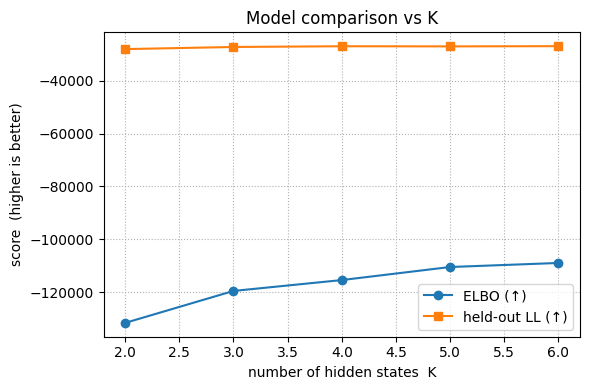

▶ Suggested K (elbow rule) = 5


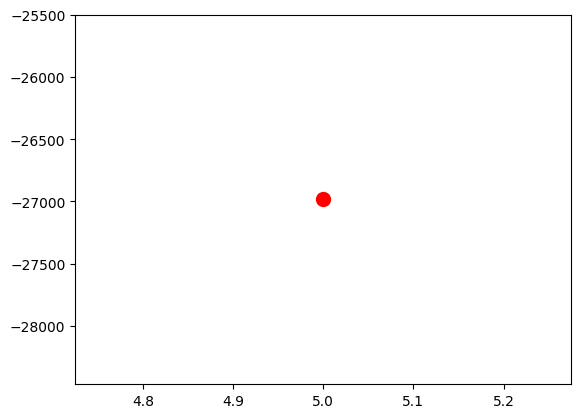

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# results = {K:{"elbo": … , "heldout": …}, …}  ← già calcolato sopra
df = pd.DataFrame(results).T.sort_index()          # rows = K
display(df)

# ── 1. Plot ELBO and held-out log-likelihood ─────────────────────────────
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df.index, df["elbo"],    "o-", label="ELBO (↑)")
ax.plot(df.index, df["heldout"], "s-", label="held-out LL (↑)")
ax.set_xlabel("number of hidden states  K")
ax.set_ylabel("score  (higher is better)")
ax.set_title("Model comparison vs K")
ax.grid(True, ls=":")
ax.legend()
plt.tight_layout()
plt.show()

# ── 2. Find “elbow” automatically (simple ∆-gain rule) ───────────────────
def detect_elbow(series, min_gain=100.0):
    """Return smallest K where incremental gain < min_gain."""
    diffs = series.diff().iloc[1:]        # Δscore(K) = score(K)–score(K-1)
    mask  = diffs.abs() < min_gain
    return mask.idxmax() if mask.any() else series.index[-1]

best_K = detect_elbow(df["heldout"], min_gain=100.)   # tweak threshold!
print(f"▶ Suggested K (elbow rule) = {best_K}")

# ── 3. Highlight choice on the plot ──────────────────────────────────────
ax = plt.gca()
ax.plot(best_K, df.loc[best_K, "heldout"], "ro", ms=10)
plt.show()